In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False
)

classes = trainset.classes
classes

Files already downloaded and verified
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

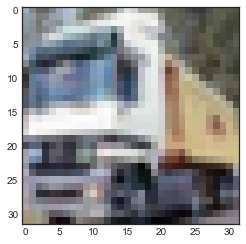

In [3]:
import matplotlib.pyplot as plt

images=train_loader.dataset[1][0]
plt.imshow(images.permute(1, 2, 0))

In [4]:
images.size()

torch.Size([3, 32, 32])

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3개의 색 채널을 인풋으로, 아웃풋 6개, cunel size = 5
        self.pool = nn.MaxPool2d(2, 2)#size를 줄인다.
        self.conv2 = nn.Conv2d(6, 16, 5) #6개의 인풋, 16개 아웃풋, cunel size = 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #fully connected layer
        self.fc2 = nn.Linear(120, 84) #인풋은 이전 과정의 아웃풋에 맞춤
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 뺀 차원을 평탄화(flatten)한다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#CrossEntropyLoss를 사용하고 optimizer로 SGD사용, lerning late는 0.001로 momentum=0.9로 로컬미니멈을 피한다.

In [7]:
for epoch in range(3): #3 번 반복한다.

    running_loss = 0.0 #오차를 초기화한다.
    for i, data in enumerate(train_loader, 0): #데이터를 가져와서 하나씩 분할하겠다.
        inputs, labels = data #그림4개(batch size)를 인풋 , 오른쪽에 클래스를 label로 넣겠다.

        optimizer.zero_grad() #grad를 초기화시킨다.

       
        outputs = net(inputs)#forward
        loss = criterion(outputs, labels)#loss계산
        loss.backward()#loss backpropagation
        optimizer.step() # optimizer로 최적화한다.

        
        running_loss += loss.item() #최종 loss구하기
        if i % 2000 == 1999:    #2000번에 한 번씩 loss를 출력한다.
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished')

[1,  2000] loss: 2.242
[1,  4000] loss: 2.024
[1,  6000] loss: 1.894
[1,  8000] loss: 1.757
[1, 10000] loss: 1.645
[1, 12000] loss: 1.556
[2,  2000] loss: 1.510
[2,  4000] loss: 1.481
[2,  6000] loss: 1.460
[2,  8000] loss: 1.425
[2, 10000] loss: 1.397
[2, 12000] loss: 1.379
[3,  2000] loss: 1.327
[3,  4000] loss: 1.331
[3,  6000] loss: 1.320
[3,  8000] loss: 1.307
[3, 10000] loss: 1.313
[3, 12000] loss: 1.306
Finished


In [8]:
correct = 0 
total = 0 #correct, total 0으로 초기화
with torch.no_grad(): #테스트니 그래디언트를 안씀
    for data in test_loader: # test data사용
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) #test data로 prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)) #정확도 출력

Accuracy of the network on the 10000 test images: 54 %


batch를 4개로 사용하고 convolution layer로 conv2d를 사용했다.
rgb로 conv1에서는 인풋에 3개의 채널을 사용했고 두 개의 convolution layer사이에 pooling을 수행했다.
lerning rate를 작게 사용하고 local minimum을 피하기위해 momentum을 조금 사용했으며 training 중에는 2000번에 한 번씩 loss를 출력해 loss가 줄어드는 것을 확인했다.
test 데이터를 사용해서 트레이닝의 정확도를 출력했다.
epoch를 2~4까지 변화시키며 해봤지만 그 때 그 때 정확도가 가장 높은 epoch가 바뀌는 것으로 보아 momentum의 문제인가 생각했지만 큰 차이가 나지않아서 momentum은 그냥 0.9로 사용했습니다.

